This code serves for the 6th homework in Computational Neuroscicence taught by Xiao-Jing Wang in Fall 2022 semester. 

Notice that the codes for each subsection in this HW are more or less similar. The only changes would be changes of parameters.  

### Question 1: Part a-c

0.12807265447975058
2.501970689288233


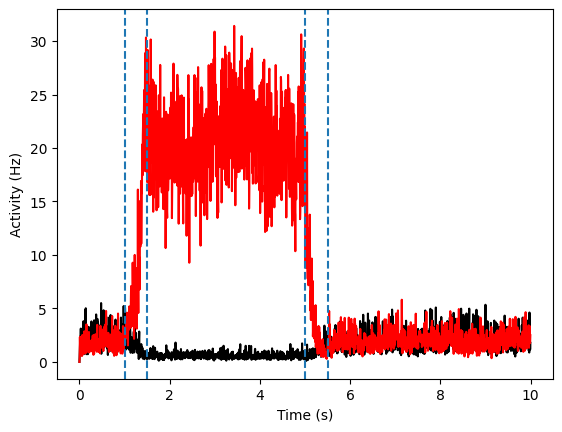

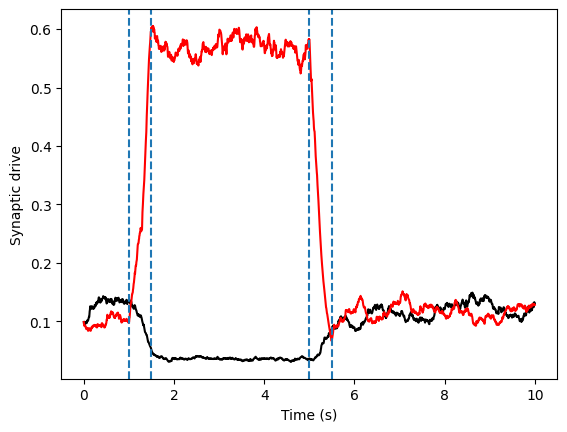

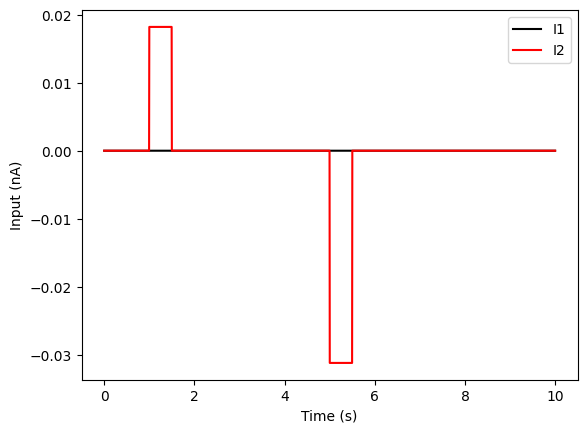

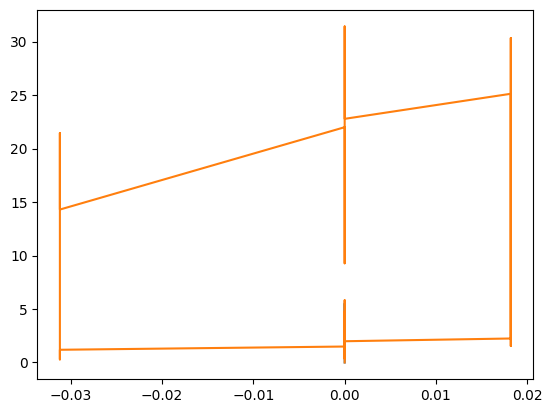

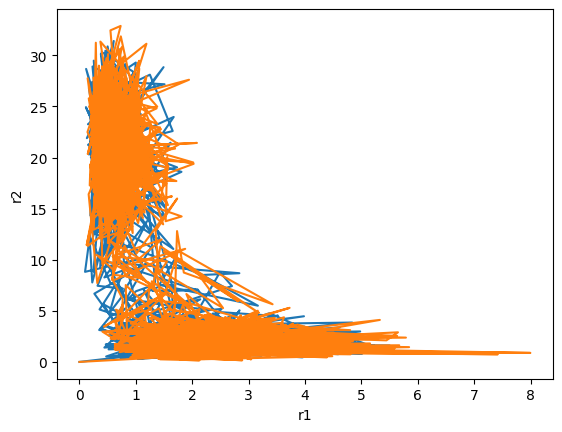

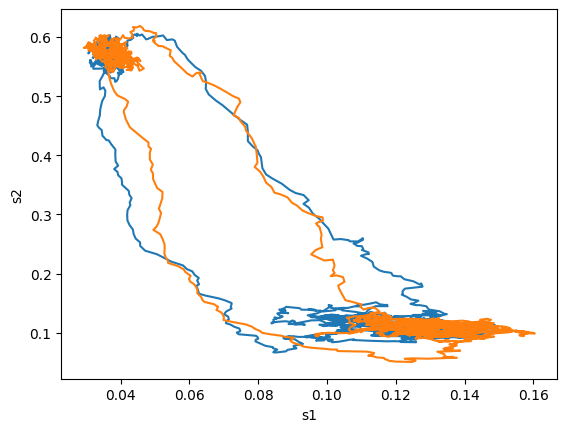

In [403]:
from __future__ import division
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import matplotlib as mpl


def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))

modelparams = dict(
    gE          = 0.2609,  # nA
    gI          = -0.0497, # cross-inhibition strength [nA] % 
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [s]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu1         = [35,-60], # Stimulus firing rate [Hz] mu_1
    mu2         = [0,0], # Stimulus firing rate [Hz] mu_2
    Jext        = 0.00052, # Stimulus input strength [nA/Hz]

    # Simulation Run-Time parameter
    Ttotal      = 10, # Total duration of simulation [s]
    Tstim_on    = [1,5.0], # Time of stimulus onset
    Tstim_off   = [1.5,5.5], # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)

class Model(object):
    def __init__(self, modelparams):
        self.params = modelparams.copy()

    # if symmetry index = 0, apply stimulus by mu_1
    # if symmetry index = 1, apply stimulus by mu_2
    def run(self, n_trial=1,symmetryindex=0):
        p = self.params

        NT = int(p['Ttotal']/p['dt'])
        t_plot = np.arange(NT)*p['dt']
        t_stim1 = (t_plot>p['Tstim_on'][0]) * (t_plot<p['Tstim_off'][0])
        if len(p['Tstim_on']) > 1:
            t_stim2 = (t_plot>p['Tstim_on'][1]) * (t_plot<p['Tstim_off'][1])

        # change order
        if symmetryindex == 1:
            temp = p['mu1']
            p['mu1'] = p['mu2']
            p['mu2'] = temp
   
        # Define g_{ext}\mu_2
        mean_stim1 = np.ones(NT)*p['mu1'][0]*p['Jext'] # [nA]
        mean_stim2 = np.ones(NT)*p['mu2'][0]*p['Jext'] # [nA]
        Istim1_plot1 = mean_stim1 * t_stim1
        Istim2_plot1 = mean_stim2 * t_stim1
        if len(p['Tstim_on']) > 1:
            mean_stim1 = np.ones(NT)*p['mu1'][1]*p['Jext'] # [nA]
            mean_stim2 = np.ones(NT)*p['mu2'][1]*p['Jext'] # [nA]
            Istim1_plot2 = mean_stim1 * t_stim2
            Istim2_plot2 = mean_stim2 * t_stim2
            Istim1_plot = Istim1_plot1 + Istim1_plot2
            Istim2_plot = Istim2_plot1 + Istim2_plot2
        else:
            Istim1_plot = Istim1_plot1
            Istim2_plot = Istim2_plot1
           
        s_0 = 0.1 # initial condition of s
        # Initialize S1 and S2
        S1 = s_0*np.ones(n_trial)
        S2 = s_0*np.ones(n_trial)

        Ieta1 = np.zeros(n_trial)
        Ieta2 = np.zeros(n_trial)

        n_record = int(p['record_dt']//p['dt'])
        i_record = 0
        N_record = int(p['Ttotal']/p['record_dt'])

        self.r1 = np.zeros((N_record, n_trial))
        self.r2 = np.zeros((N_record, n_trial))
        self.s1 = np.zeros((N_record, n_trial))
        self.s2 = np.zeros((N_record, n_trial))
        self.ds1 = np.zeros((N_record, n_trial))
        self.ds2 = np.zeros((N_record, n_trial))

        self.t  = np.zeros(N_record)
        self.I1 = np.zeros(N_record)
        self.I2 = np.zeros(N_record)

        # Loop over time points in a trial
        for i_t in range(NT):
            Istim1 = Istim1_plot[i_t]
            Istim2 = Istim2_plot[i_t]

            # Total synaptic input
            Isyn1 = p['gE']*S1 + p['gI']*S2 + Istim1 + Ieta1
            Isyn2 = p['gE']*S2 + p['gI']*S1 + Istim2 + Ieta2

            # Transfer function to get firing rate
            r1  = F(Isyn1)
            r2  = F(Isyn2)

            # Equation 2 & 3
            S1_next = S1 + p['dt']*(-S1/p['tauS'] + (1-S1)*p['gamma']*r1)
            S2_next = S2 + p['dt']*(-S2/p['tauS'] + (1-S2)*p['gamma']*r2)
            thisds1 = -S1/p['tauS'] + (1-S1)*p['gamma']*r1
            thisds2 = -S2/p['tauS'] + (1-S2)*p['gamma']*r2

            # Equation 4 & 5
            Ieta1_next = Ieta1 + (p['dt']/p['tau0'])*(p['I0']-Ieta1) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)
            Ieta2_next = Ieta2 + (p['dt']/p['tau0'])*(p['I0']-Ieta2) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)

            S1 = S1_next
            S2 = S2_next
            Ieta1 = Ieta1_next
            Ieta2 = Ieta2_next

            if np.mod(i_t,n_record) == 1:
                self.r1[i_record] = r1
                self.r2[i_record] = r2
                self.s1[i_record] = S1
                self.s2[i_record] = S2
                self.ds1[i_record] = thisds1
                self.ds2[i_record] = thisds2
                self.I1[i_record] = Istim1
                self.I2[i_record] = Istim2
                self.t[i_record] = i_t*p['dt']
                i_record += 1

# color function
def colorFader(c1,c2,mix=0): 
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)


if __name__ == '__main__':
    runtrail = 1

    model = Model(modelparams)
    model.run(n_trial=runtrail,symmetryindex=1)

    model2 = Model(modelparams)
    model2.run(n_trial=runtrail,symmetryindex=1)

    s1_mean = np.mean(model.s1,1)
    s2_mean = np.mean(model.s2,1)
    r1_mean = np.mean(model.r1,1)
    r2_mean = np.mean(model.r2,1)
    s1_mean_2 = np.mean(model2.s1,1)
    s2_mean_2 = np.mean(model2.s2,1)
    r1_mean_2 = np.mean(model2.r1,1)
    r2_mean_2 = np.mean(model2.r2,1)

    print(s2_mean[-1])
    print(r2_mean[-1])

    c1='red' 
    c2='white' 
    colorset = []
    nn = len(model.r1)
    for i in range(1,nn+1):  
        colorset.append(colorFader(c1,c2,i/nn))

    plt.figure()
    plt.plot(model.t,model.r1,'black')
    plt.plot(model.t,model.r2,'red')
    plt.axvline(modelparams['Tstim_on'][0],linestyle='--')
    plt.axvline(modelparams['Tstim_off'][0],linestyle='--')
    plt.axvline(modelparams['Tstim_on'][1],linestyle='--')
    plt.axvline(modelparams['Tstim_off'][1],linestyle='--')
    plt.ylabel('Activity (Hz)')
    plt.xlabel('Time (s)')

    plt.figure()
    plt.plot(model.t,model.s1,'black')
    plt.plot(model.t,model.s2,'red')
    plt.axvline(modelparams['Tstim_on'][0],linestyle='--')
    plt.axvline(modelparams['Tstim_off'][0],linestyle='--')
    plt.axvline(modelparams['Tstim_on'][1],linestyle='--')
    plt.axvline(modelparams['Tstim_off'][1],linestyle='--')
    plt.ylabel('Synaptic drive')
    plt.xlabel('Time (s)')

    plt.figure()
    plt.plot(model.t,model.I1,'black',label='I1')
    plt.plot(model.t,model.I2,'red',label='I2')
    plt.xlabel('Time (s)')
    plt.ylabel('Input (nA)')
    plt.legend()

    runn2 = 1
    if runn2 == 1:
        plt.figure()
        plt.plot(r1_mean,r2_mean)
        plt.plot(r1_mean_2,r2_mean_2)
        plt.xlabel('r1')
        plt.ylabel('r2')

        plt.figure()
        plt.plot(s1_mean,s2_mean)
        plt.plot(s1_mean_2,s2_mean_2)
        plt.xlabel('s1')
        plt.ylabel('s2')



### Question 1: Part d

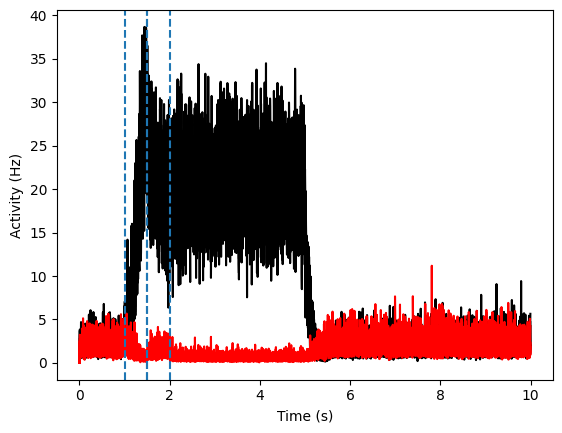

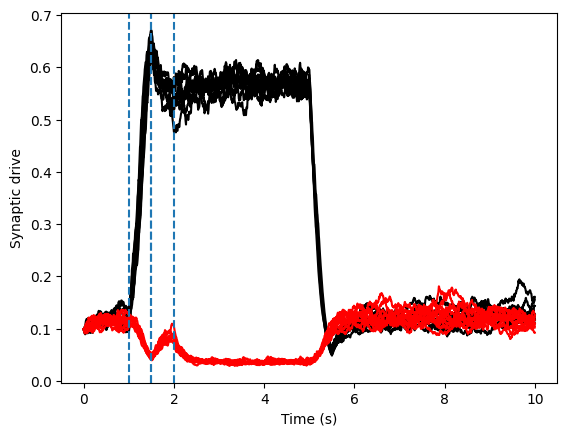

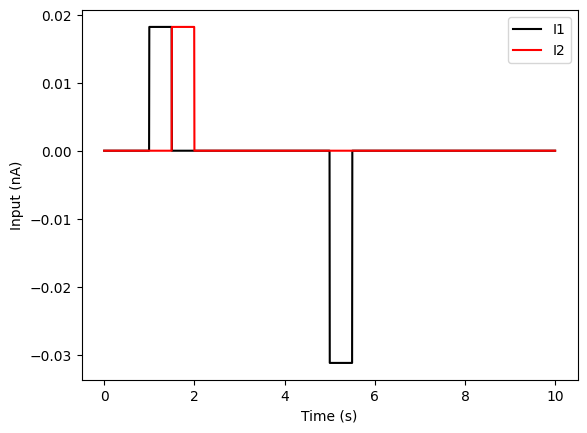

In [404]:
from __future__ import division
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import matplotlib as mpl


def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))

modelparams = dict(
    gE          = 0.2609,  # nA
    gI          = -0.0497, # cross-inhibition strength [nA] % 
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [s]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu1         = [35,0,-60], # Stimulus firing rate [Hz] mu_1
    mu2         = [0,35,0], # Stimulus firing rate [Hz] mu_2
    Jext        = 0.00052, # Stimulus input strength [nA/Hz]

    # Simulation Run-Time parameter
    Ttotal      = 10, # Total duration of simulation [s]
    Tstim_on    = [1,1.5,5.0], # Time of stimulus onset
    Tstim_off   = [1.5,2.0,5.5], # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)

class Model(object):
    def __init__(self, modelparams):
        self.params = modelparams.copy()

    # if symmetry index = 0, apply stimulus by mu_1
    # if symmetry index = 1, apply stimulus by mu_2
    def run(self, n_trial=1,symmetryindex=0):
        p = self.params

        NT = int(p['Ttotal']/p['dt'])
        t_plot = np.arange(NT)*p['dt']
        t_stim1 = (t_plot>p['Tstim_on'][0]) * (t_plot<p['Tstim_off'][0])
        if len(p['Tstim_on']) > 1:
            t_stim2 = (t_plot>p['Tstim_on'][1]) * (t_plot<p['Tstim_off'][1])
            t_stim3 = (t_plot>p['Tstim_on'][2]) * (t_plot<p['Tstim_off'][2])

        # change order
        if symmetryindex == 1:
            temp = p['mu1']
            p['mu1'] = p['mu2']
            p['mu2'] = temp
   
        # Define g_{ext}\mu_2
        mean_stim1 = np.ones(NT)*p['mu1'][0]*p['Jext'] # [nA]
        mean_stim2 = np.ones(NT)*p['mu2'][0]*p['Jext'] # [nA]
        Istim1_plot1 = mean_stim1 * t_stim1
        Istim2_plot1 = mean_stim2 * t_stim1
        if len(p['Tstim_on']) > 1:
            mean_stim1 = np.ones(NT)*p['mu1'][1]*p['Jext'] # [nA]
            mean_stim2 = np.ones(NT)*p['mu2'][1]*p['Jext'] # [nA]
            Istim1_plot2 = mean_stim1 * t_stim2
            Istim2_plot2 = mean_stim2 * t_stim2

            mean_stim1 = np.ones(NT)*p['mu1'][2]*p['Jext'] # [nA]
            mean_stim2 = np.ones(NT)*p['mu2'][2]*p['Jext'] # [nA]
            Istim1_plot3 = mean_stim1 * t_stim3
            Istim2_plot3 = mean_stim2 * t_stim3


            Istim1_plot = Istim1_plot1 + Istim1_plot2 + Istim1_plot3
            Istim2_plot = Istim2_plot1 + Istim2_plot2 + Istim2_plot3
        else:
            Istim1_plot = Istim1_plot1
            Istim2_plot = Istim2_plot1
           
        s_0 = 0.1 # initial condition of s
        # Initialize S1 and S2
        S1 = s_0*np.ones(n_trial)
        S2 = s_0*np.ones(n_trial)

        Ieta1 = np.zeros(n_trial)
        Ieta2 = np.zeros(n_trial)

        n_record = int(p['record_dt']//p['dt'])
        i_record = 0
        N_record = int(p['Ttotal']/p['record_dt'])

        self.r1 = np.zeros((N_record, n_trial))
        self.r2 = np.zeros((N_record, n_trial))
        self.s1 = np.zeros((N_record, n_trial))
        self.s2 = np.zeros((N_record, n_trial))
        self.ds1 = np.zeros((N_record, n_trial))
        self.ds2 = np.zeros((N_record, n_trial))

        self.t  = np.zeros(N_record)
        self.I1 = np.zeros(N_record)
        self.I2 = np.zeros(N_record)

        # Loop over time points in a trial
        for i_t in range(NT):
            Istim1 = Istim1_plot[i_t]
            Istim2 = Istim2_plot[i_t]

            # Total synaptic input
            Isyn1 = p['gE']*S1 + p['gI']*S2 + Istim1 + Ieta1
            Isyn2 = p['gE']*S2 + p['gI']*S1 + Istim2 + Ieta2

            # Transfer function to get firing rate
            r1  = F(Isyn1)
            r2  = F(Isyn2)

            # Equation 2 & 3
            S1_next = S1 + p['dt']*(-S1/p['tauS'] + (1-S1)*p['gamma']*r1)
            S2_next = S2 + p['dt']*(-S2/p['tauS'] + (1-S2)*p['gamma']*r2)
            thisds1 = -S1/p['tauS'] + (1-S1)*p['gamma']*r1
            thisds2 = -S2/p['tauS'] + (1-S2)*p['gamma']*r2

            # Equation 4 & 5
            Ieta1_next = Ieta1 + (p['dt']/p['tau0'])*(p['I0']-Ieta1) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)
            Ieta2_next = Ieta2 + (p['dt']/p['tau0'])*(p['I0']-Ieta2) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)

            S1 = S1_next
            S2 = S2_next
            Ieta1 = Ieta1_next
            Ieta2 = Ieta2_next

            if np.mod(i_t,n_record) == 1:
                self.r1[i_record] = r1
                self.r2[i_record] = r2
                self.s1[i_record] = S1
                self.s2[i_record] = S2
                self.ds1[i_record] = thisds1
                self.ds2[i_record] = thisds2
                self.I1[i_record] = Istim1
                self.I2[i_record] = Istim2
                self.t[i_record] = i_t*p['dt']
                i_record += 1

# color function
def colorFader(c1,c2,mix=0): 
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)


if __name__ == '__main__':
    runtrail = 10

    model = Model(modelparams)
    model.run(n_trial=runtrail,symmetryindex=0)

    model2 = Model(modelparams)
    model2.run(n_trial=runtrail,symmetryindex=1)

    c1='red' 
    c2='white' 
    colorset = []
    nn = len(model.r1)
    for i in range(1,nn+1):  
        colorset.append(colorFader(c1,c2,i/nn))

    plt.figure()
    plt.plot(model.t,model.r1,'black')
    plt.plot(model.t,model.r2,'red')
    plt.axvline(modelparams['Tstim_on'][0],linestyle='--')
    plt.axvline(modelparams['Tstim_off'][0],linestyle='--')
    plt.axvline(modelparams['Tstim_on'][1],linestyle='--')
    plt.axvline(modelparams['Tstim_off'][1],linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Activity (Hz)')

    plt.figure()
    plt.plot(model.t,model.s1,'black')
    plt.plot(model.t,model.s2,'red')
    plt.axvline(modelparams['Tstim_on'][0],linestyle='--')
    plt.axvline(modelparams['Tstim_off'][0],linestyle='--')
    plt.axvline(modelparams['Tstim_on'][1],linestyle='--')
    plt.axvline(modelparams['Tstim_off'][1],linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Synaptic drive')

    plt.figure()
    plt.plot(model.t,model.I1,'black',label='I1')
    plt.plot(model.t,model.I2,'red',label='I2')
    plt.xlabel('Time (s)')
    plt.ylabel('Input (nA)')
    plt.legend()

    s1_mean = np.mean(model.s1,1)
    s2_mean = np.mean(model.s2,1)
    r1_mean = np.mean(model.r1,1)
    r2_mean = np.mean(model.r2,1)
    s1_mean_2 = np.mean(model2.s1,1)
    s2_mean_2 = np.mean(model2.s2,1)
    r1_mean_2 = np.mean(model2.r1,1)
    r2_mean_2 = np.mean(model2.r2,1)



### Question 1: Part e

In [405]:
from __future__ import division
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import matplotlib as mpl


def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))

modelparams = dict(
    gE          = 0.2609,  # nA
    gI          = -0.0497, # cross-inhibition strength [nA] % 
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [s]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu1         = [35,0], # Stimulus firing rate [Hz] mu_1
    mu2         = [0,0], # Stimulus firing rate [Hz] mu_2
    Jext        = 0.00052, # Stimulus input strength [nA/Hz]

    # Simulation Run-Time parameter
    Ttotal      = 10, # Total duration of simulation [s]
    Tstim_on    = [1,1.5], # Time of stimulus onset
    Tstim_off   = [1.5,2.0], # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)

class Model(object):
    def __init__(self, modelparams):
        self.params = modelparams.copy()

    # if symmetry index = 0, apply stimulus by mu_1
    # if symmetry index = 1, apply stimulus by mu_2
    def run(self, n_trial=1,symmetryindex=0,geval=0.2609):
        p = self.params

        p['gE'] = geval

        NT = int(p['Ttotal']/p['dt'])
        t_plot = np.arange(NT)*p['dt']
        t_stim1 = (t_plot>p['Tstim_on'][0]) * (t_plot<p['Tstim_off'][0])
        if len(p['Tstim_on']) > 1:
            t_stim2 = (t_plot>p['Tstim_on'][1]) * (t_plot<p['Tstim_off'][1])

        # change order
        if symmetryindex == 1:
            temp = p['mu1']
            p['mu1'] = p['mu2']
            p['mu2'] = temp
   
        # Define g_{ext}\mu_2
        mean_stim1 = np.ones(NT)*p['mu1'][0]*p['Jext'] # [nA]
        mean_stim2 = np.ones(NT)*p['mu2'][0]*p['Jext'] # [nA]
        Istim1_plot1 = mean_stim1 * t_stim1
        Istim2_plot1 = mean_stim2 * t_stim1
        if len(p['Tstim_on']) > 1:
            mean_stim1 = np.ones(NT)*p['mu1'][1]*p['Jext'] # [nA]
            mean_stim2 = np.ones(NT)*p['mu2'][1]*p['Jext'] # [nA]
            Istim1_plot2 = mean_stim1 * t_stim2
            Istim2_plot2 = mean_stim2 * t_stim2
            Istim1_plot = Istim1_plot1 + Istim1_plot2
            Istim2_plot = Istim2_plot1 + Istim2_plot2
        else:
            Istim1_plot = Istim1_plot1
            Istim2_plot = Istim2_plot1
           
        s_0 = 0.1 # initial condition of s
        # Initialize S1 and S2
        S1 = s_0*np.ones(n_trial)
        S2 = s_0*np.ones(n_trial)

        Ieta1 = np.zeros(n_trial)
        Ieta2 = np.zeros(n_trial)

        n_record = int(p['record_dt']//p['dt'])
        i_record = 0
        N_record = int(p['Ttotal']/p['record_dt'])

        self.r1 = np.zeros((N_record, n_trial))
        self.r2 = np.zeros((N_record, n_trial))
        self.s1 = np.zeros((N_record, n_trial))
        self.s2 = np.zeros((N_record, n_trial))
        self.ds1 = np.zeros((N_record, n_trial))
        self.ds2 = np.zeros((N_record, n_trial))

        self.t  = np.zeros(N_record)
        self.I1 = np.zeros(N_record)
        self.I2 = np.zeros(N_record)

        # Loop over time points in a trial
        for i_t in range(NT):
            Istim1 = Istim1_plot[i_t]
            Istim2 = Istim2_plot[i_t]

            # Total synaptic input
            Isyn1 = p['gE']*S1 + p['gI']*S2 + Istim1 + Ieta1
            Isyn2 = p['gE']*S2 + p['gI']*S1 + Istim2 + Ieta2

            # Transfer function to get firing rate
            r1  = F(Isyn1)
            r2  = F(Isyn2)

            # Equation 2 & 3
            S1_next = S1 + p['dt']*(-S1/p['tauS'] + (1-S1)*p['gamma']*r1)
            S2_next = S2 + p['dt']*(-S2/p['tauS'] + (1-S2)*p['gamma']*r2)
            thisds1 = -S1/p['tauS'] + (1-S1)*p['gamma']*r1
            thisds2 = -S2/p['tauS'] + (1-S2)*p['gamma']*r2

            # Equation 4 & 5
            Ieta1_next = Ieta1 + (p['dt']/p['tau0'])*(p['I0']-Ieta1) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)
            Ieta2_next = Ieta2 + (p['dt']/p['tau0'])*(p['I0']-Ieta2) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)

            S1 = S1_next
            S2 = S2_next
            Ieta1 = Ieta1_next
            Ieta2 = Ieta2_next

            if np.mod(i_t,n_record) == 1:
                self.r1[i_record] = r1
                self.r2[i_record] = r2
                self.s1[i_record] = S1
                self.s2[i_record] = S2
                self.ds1[i_record] = thisds1
                self.ds2[i_record] = thisds2
                self.I1[i_record] = Istim1
                self.I2[i_record] = Istim2
                self.t[i_record] = i_t*p['dt']
                i_record += 1

# color function
def colorFader(c1,c2,mix=0): 
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)


if __name__ == '__main__':
    runtrail = 500

    geset = np.linspace(0.2609,0.2509,num=21)
    plt.figure(figsize=(8,8))
    for ge in geset:
        model = Model(modelparams)
        model.run(n_trial=runtrail,symmetryindex=0,geval=ge)

        s1_mean = np.mean(model.s1,1)
        s2_mean = np.mean(model.s2,1)
        r1_mean = np.mean(model.r1,1)
        r2_mean = np.mean(model.r2,1)
        ds1_mean = np.mean(model.ds1,1)
        ds2_mean = np.mean(model.ds2,1)

        plt.plot(model.t,s1_mean,label=f'ge={ge}')
    plt.legend()
    plt.xlabel('Time')

KeyboardInterrupt: 

<Figure size 800x800 with 0 Axes>

### Question 2

s1-prefer:0.0%; s2-prefer:100.0%


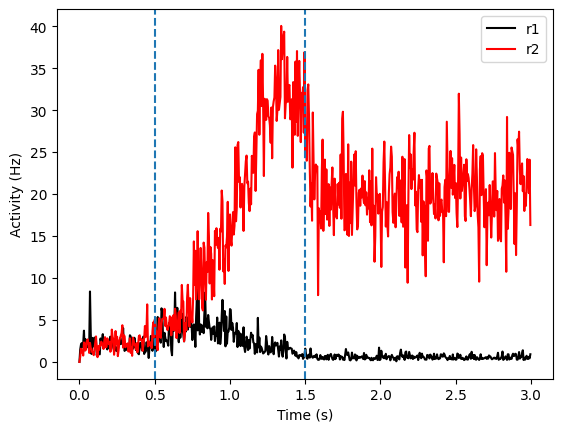

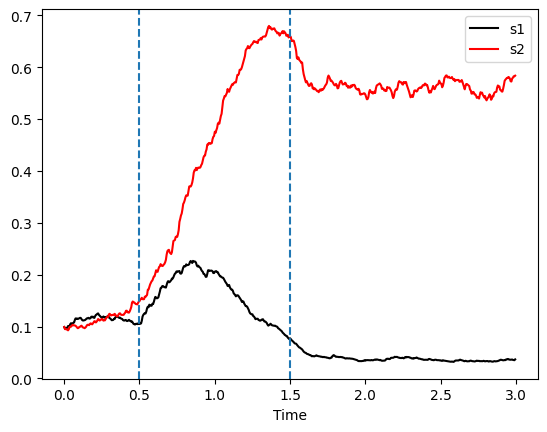

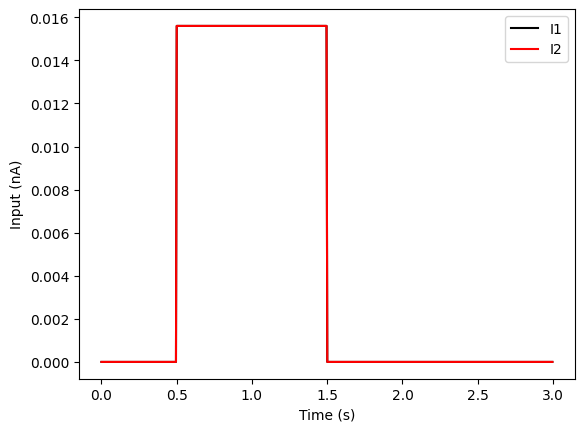

In [ ]:
from __future__ import division
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import matplotlib as mpl


def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))

modelparams = dict(
    gE          = 0.2609,  # nA
    gI          = -0.0497, # cross-inhibition strength [nA] % 
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [s]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu1         = [30], # Stimulus firing rate [Hz] mu_1
    mu2         = [30], # Stimulus firing rate [Hz] mu_2
    Jext        = 0.00052, # Stimulus input strength [nA/Hz]

    # Simulation Run-Time parameter
    Ttotal      = 3, # Total duration of simulation [s]
    Tstim_on    = [0.5], # Time of stimulus onset
    Tstim_off   = [1.5], # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)

class Model(object):
    def __init__(self, modelparams):
        self.params = modelparams.copy()

    # if symmetry index = 0, apply stimulus by mu_1
    # if symmetry index = 1, apply stimulus by mu_2
    def run(self, n_trial=1,symmetryindex=0):
        np.random.seed()

        p = self.params
        NT = int(p['Ttotal']/p['dt'])
        t_plot = np.arange(NT)*p['dt']
        t_stim1 = (t_plot>p['Tstim_on'][0]) * (t_plot<p['Tstim_off'][0])
        if len(p['Tstim_on']) > 1:
            t_stim2 = (t_plot>p['Tstim_on'][1]) * (t_plot<p['Tstim_off'][1])

        # change order
        if symmetryindex == 1:
            temp = p['mu1']
            p['mu1'] = p['mu2']
            p['mu2'] = temp
   
        # Define g_{ext}\mu_2
        mean_stim1 = np.ones(NT)*p['mu1'][0]*p['Jext'] # [nA]
        mean_stim2 = np.ones(NT)*p['mu2'][0]*p['Jext'] # [nA]
        Istim1_plot1 = mean_stim1 * t_stim1
        Istim2_plot1 = mean_stim2 * t_stim1
        if len(p['Tstim_on']) > 1:
            mean_stim1 = np.ones(NT)*p['mu1'][1]*p['Jext'] # [nA]
            mean_stim2 = np.ones(NT)*p['mu2'][1]*p['Jext'] # [nA]
            Istim1_plot2 = mean_stim1 * t_stim2
            Istim2_plot2 = mean_stim2 * t_stim2
            Istim1_plot = Istim1_plot1 + Istim1_plot2
            Istim2_plot = Istim2_plot1 + Istim2_plot2
        else:
            Istim1_plot = Istim1_plot1
            Istim2_plot = Istim2_plot1
           
        s_0 = 0.1 # initial condition of s
        # Initialize S1 and S2
        S1 = s_0*np.ones(n_trial)
        S2 = s_0*np.ones(n_trial)

        Ieta1 = np.zeros(n_trial)
        Ieta2 = np.zeros(n_trial)

        n_record = int(p['record_dt']//p['dt'])
        i_record = 0
        N_record = int(p['Ttotal']/p['record_dt'])

        self.r1 = np.zeros((N_record, n_trial))
        self.r2 = np.zeros((N_record, n_trial))
        self.s1 = np.zeros((N_record, n_trial))
        self.s2 = np.zeros((N_record, n_trial))
        self.ds1 = np.zeros((N_record, n_trial))
        self.ds2 = np.zeros((N_record, n_trial))

        self.t  = np.zeros(N_record)
        self.I1 = np.zeros(N_record)
        self.I2 = np.zeros(N_record)

        # Loop over time points in a trial
        for i_t in range(NT):
            Istim1 = Istim1_plot[i_t]
            Istim2 = Istim2_plot[i_t]

            # Total synaptic input
            Isyn1 = p['gE']*S1 + p['gI']*S2 + Istim1 + Ieta1
            Isyn2 = p['gE']*S2 + p['gI']*S1 + Istim2 + Ieta2

            # Transfer function to get firing rate
            r1  = F(Isyn1)
            r2  = F(Isyn2)

            # Equation 2 & 3
            S1_next = S1 + p['dt']*(-S1/p['tauS'] + (1-S1)*p['gamma']*r1)
            S2_next = S2 + p['dt']*(-S2/p['tauS'] + (1-S2)*p['gamma']*r2)
            thisds1 = -S1/p['tauS'] + (1-S1)*p['gamma']*r1
            thisds2 = -S2/p['tauS'] + (1-S2)*p['gamma']*r2

            # Equation 4 & 5
            Ieta1_next = Ieta1 + (p['dt']/p['tau0'])*(p['I0']-Ieta1) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)
            Ieta2_next = Ieta2 + (p['dt']/p['tau0'])*(p['I0']-Ieta2) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)

            S1 = S1_next
            S2 = S2_next
            Ieta1 = Ieta1_next
            Ieta2 = Ieta2_next

            if np.mod(i_t,n_record) == 1:
                self.r1[i_record] = r1
                self.r2[i_record] = r2
                self.s1[i_record] = S1
                self.s2[i_record] = S2
                self.ds1[i_record] = thisds1
                self.ds2[i_record] = thisds2
                self.I1[i_record] = Istim1
                self.I2[i_record] = Istim2
                self.t[i_record] = i_t*p['dt']
                i_record += 1

# color function
def colorFader(c1,c2,mix=0): 
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)


if __name__ == '__main__':
    runtrail = 1
    rerun = 1
    s1prefer = 0

    for i in range(rerun):
        model = Model(modelparams)
        model.run(n_trial=runtrail,symmetryindex=0)

        if np.mean(model.r1) > np.mean(model.r2):
            s1prefer += 1

        plt.figure()
        plt.plot(model.t,model.r1,'black',label='r1')
        plt.plot(model.t,model.r2,'red',label='r2')
        plt.axvline(modelparams['Tstim_on'][0],linestyle='--')
        plt.axvline(modelparams['Tstim_off'][0],linestyle='--')
        plt.legend()
        plt.xlabel('Time (s)')
        plt.ylabel('Activity (Hz)')

        plt.figure()
        plt.plot(model.t,model.s1,'black',label='s1')
        plt.plot(model.t,model.s2,'red',label='s2')
        plt.axvline(modelparams['Tstim_on'][0],linestyle='--')
        plt.axvline(modelparams['Tstim_off'][0],linestyle='--')
        plt.legend()
        plt.xlabel('Time')

        plt.figure()
        plt.plot(model.t,model.I1,'black',label='I1')
        plt.plot(model.t,model.I2,'red',label='I2')
        plt.xlabel('Time (s)')
        plt.ylabel('Input (nA)')
        plt.legend()
    print(f"s1-prefer:{s1prefer/rerun*100}%; s2-prefer:{(rerun-s1prefer)/rerun*100}%")



### Question 3

In [ ]:
from __future__ import division
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import matplotlib as mpl


def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))

modelparams = dict(
    gE          = 0.2609,  # nA
    gI          = -0.0497, # cross-inhibition strength [nA] % 
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [s]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu1         = [30], # Stimulus firing rate [Hz] mu_1
    mu2         = [30], # Stimulus firing rate [Hz] mu_2
    Jext        = 0.00052, # Stimulus input strength [nA/Hz]

    # Simulation Run-Time parameter
    Ttotal      = 3, # Total duration of simulation [s]
    Tstim_on    = [0.5], # Time of stimulus onset
    Tstim_off   = [1.5], # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)

class Model(object):
    def __init__(self, modelparams):
        self.params = modelparams.copy()

    # if symmetry index = 0, apply stimulus by mu_1
    # if symmetry index = 1, apply stimulus by mu_2
    def run(self, n_trial=1,symmetryindex=0,cdot=1,mu0=30):
        p = self.params

        p['mu1'] = [mu0*(1+cdot)]
        p['mu2'] = [mu0*(1-cdot)]

        NT = int(p['Ttotal']/p['dt'])
        t_plot = np.arange(NT)*p['dt']
        t_stim1 = (t_plot>p['Tstim_on'][0]) * (t_plot<p['Tstim_off'][0])
        if len(p['Tstim_on']) > 1:
            t_stim2 = (t_plot>p['Tstim_on'][1]) * (t_plot<p['Tstim_off'][1])

        # change order
        if symmetryindex == 1:
            temp = p['mu1']
            p['mu1'] = p['mu2']
            p['mu2'] = temp
   
        # Define g_{ext}\mu_2
        mean_stim1 = np.ones(NT)*p['mu1'][0]*p['Jext'] # [nA]
        mean_stim2 = np.ones(NT)*p['mu2'][0]*p['Jext'] # [nA]
        Istim1_plot1 = mean_stim1 * t_stim1
        Istim2_plot1 = mean_stim2 * t_stim1
        if len(p['Tstim_on']) > 1:
            mean_stim1 = np.ones(NT)*p['mu1'][1]*p['Jext'] # [nA]
            mean_stim2 = np.ones(NT)*p['mu2'][1]*p['Jext'] # [nA]
            Istim1_plot2 = mean_stim1 * t_stim2
            Istim2_plot2 = mean_stim2 * t_stim2
            Istim1_plot = Istim1_plot1 + Istim1_plot2
            Istim2_plot = Istim2_plot1 + Istim2_plot2
        else:
            Istim1_plot = Istim1_plot1
            Istim2_plot = Istim2_plot1
           
        s_0 = 0.1 # initial condition of s
        # Initialize S1 and S2
        S1 = s_0*np.ones(n_trial)
        S2 = s_0*np.ones(n_trial)

        Ieta1 = np.zeros(n_trial)
        Ieta2 = np.zeros(n_trial)

        n_record = int(p['record_dt']//p['dt'])
        i_record = 0
        N_record = int(p['Ttotal']/p['record_dt'])

        self.r1 = np.zeros((N_record, n_trial))
        self.r2 = np.zeros((N_record, n_trial))
        self.s1 = np.zeros((N_record, n_trial))
        self.s2 = np.zeros((N_record, n_trial))
        self.ds1 = np.zeros((N_record, n_trial))
        self.ds2 = np.zeros((N_record, n_trial))

        self.t  = np.zeros(N_record)
        self.I1 = np.zeros(N_record)
        self.I2 = np.zeros(N_record)

        # Loop over time points in a trial
        for i_t in range(NT):
            Istim1 = Istim1_plot[i_t]
            Istim2 = Istim2_plot[i_t]

            # Total synaptic input
            Isyn1 = p['gE']*S1 + p['gI']*S2 + Istim1 + Ieta1
            Isyn2 = p['gE']*S2 + p['gI']*S1 + Istim2 + Ieta2

            # Transfer function to get firing rate
            r1  = F(Isyn1)
            r2  = F(Isyn2)

            # Equation 2 & 3
            S1_next = S1 + p['dt']*(-S1/p['tauS'] + (1-S1)*p['gamma']*r1)
            S2_next = S2 + p['dt']*(-S2/p['tauS'] + (1-S2)*p['gamma']*r2)
            thisds1 = -S1/p['tauS'] + (1-S1)*p['gamma']*r1
            thisds2 = -S2/p['tauS'] + (1-S2)*p['gamma']*r2

            # Equation 4 & 5
            Ieta1_next = Ieta1 + (p['dt']/p['tau0'])*(p['I0']-Ieta1) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)
            Ieta2_next = Ieta2 + (p['dt']/p['tau0'])*(p['I0']-Ieta2) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)

            S1 = S1_next
            S2 = S2_next
            Ieta1 = Ieta1_next
            Ieta2 = Ieta2_next

            if np.mod(i_t,n_record) == 1:
                self.r1[i_record] = r1
                self.r2[i_record] = r2
                self.s1[i_record] = S1
                self.s2[i_record] = S2
                self.ds1[i_record] = thisds1
                self.ds2[i_record] = thisds2
                self.I1[i_record] = Istim1
                self.I2[i_record] = Istim2
                self.t[i_record] = i_t*p['dt']
                i_record += 1


if __name__ == '__main__':
    runtrail = 1
    rerun = 100

    cdotset = [0.032,0.064,0.128,0.256,0.512,0.85,1.0]
    mu0val = 30
    s1preferset = []

    for cdotval in cdotset:
        s1prefer = 0
        for i in range(rerun):
            model = Model(modelparams)
            model.run(n_trial=runtrail,symmetryindex=0,cdot=cdotval,mu0=mu0val)
            if np.mean(model.r1) > np.mean(model.r2):
                s1prefer += 1
        s1preferset.append(s1prefer/rerun)

    plt.figure()
    plt.plot(np.log(cdotset),s1preferset,'-o')
    plt.xlabel("log(c')")
    plt.ylabel('Percentage of correct decisions')

KeyboardInterrupt: 

### Question 4a

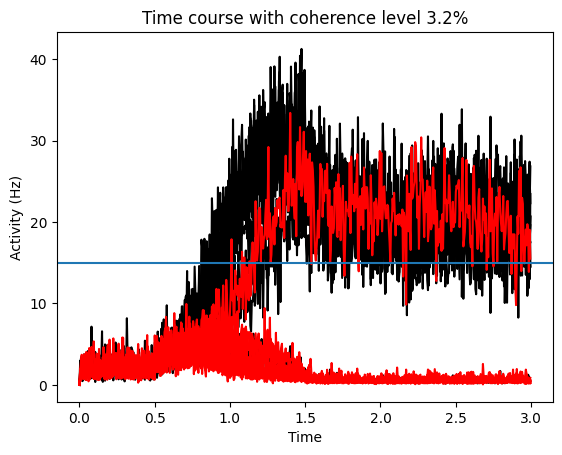

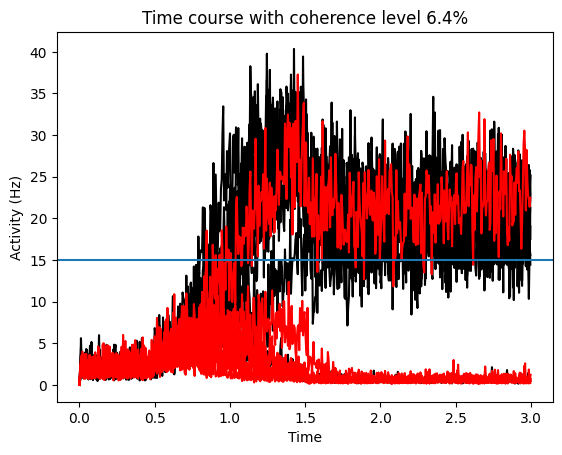

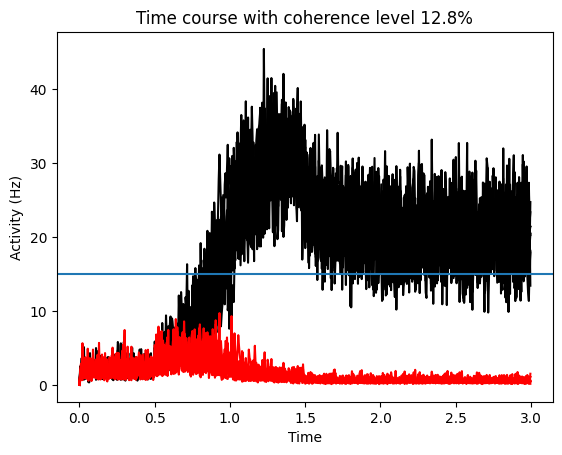

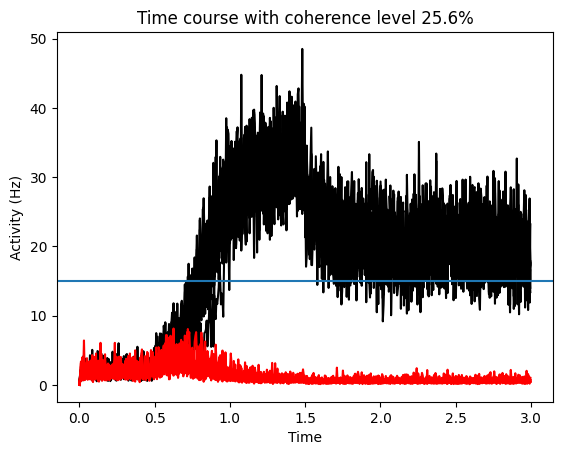

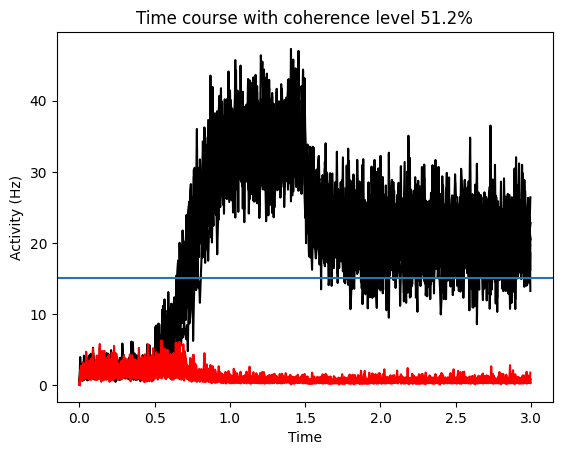

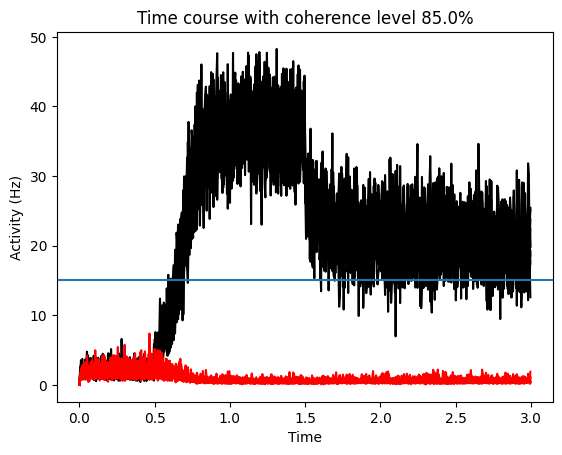

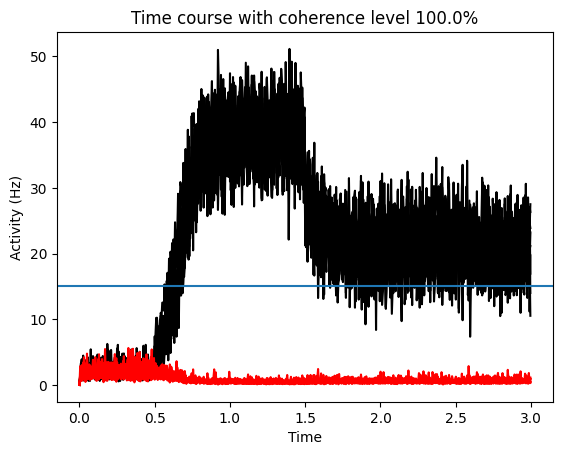

In [ ]:
from __future__ import division
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import matplotlib as mpl


def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))

modelparams = dict(
    gE          = 0.2609,  # nA
    gI          = -0.0497, # cross-inhibition strength [nA] % 
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [s]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu1         = [30], # Stimulus firing rate [Hz] mu_1
    mu2         = [30], # Stimulus firing rate [Hz] mu_2
    Jext        = 0.00052, # Stimulus input strength [nA/Hz]

    # Simulation Run-Time parameter
    Ttotal      = 3, # Total duration of simulation [s]
    Tstim_on    = [0.5], # Time of stimulus onset
    Tstim_off   = [1.5], # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)

class Model(object):
    def __init__(self, modelparams):
        self.params = modelparams.copy()

    # if symmetry index = 0, apply stimulus by mu_1
    # if symmetry index = 1, apply stimulus by mu_2
    def run(self, n_trial=1,symmetryindex=0,cdot=1,mu0=30):
        p = self.params

        p['mu1'] = [mu0*(1+cdot)]
        p['mu2'] = [mu0*(1-cdot)]

        NT = int(p['Ttotal']/p['dt'])
        t_plot = np.arange(NT)*p['dt']
        t_stim1 = (t_plot>p['Tstim_on'][0]) * (t_plot<p['Tstim_off'][0])
        if len(p['Tstim_on']) > 1:
            t_stim2 = (t_plot>p['Tstim_on'][1]) * (t_plot<p['Tstim_off'][1])

        # change order
        if symmetryindex == 1:
            temp = p['mu1']
            p['mu1'] = p['mu2']
            p['mu2'] = temp
   
        # Define g_{ext}\mu_2
        mean_stim1 = np.ones(NT)*p['mu1'][0]*p['Jext'] # [nA]
        mean_stim2 = np.ones(NT)*p['mu2'][0]*p['Jext'] # [nA]
        Istim1_plot1 = mean_stim1 * t_stim1
        Istim2_plot1 = mean_stim2 * t_stim1
        if len(p['Tstim_on']) > 1:
            mean_stim1 = np.ones(NT)*p['mu1'][1]*p['Jext'] # [nA]
            mean_stim2 = np.ones(NT)*p['mu2'][1]*p['Jext'] # [nA]
            Istim1_plot2 = mean_stim1 * t_stim2
            Istim2_plot2 = mean_stim2 * t_stim2
            Istim1_plot = Istim1_plot1 + Istim1_plot2
            Istim2_plot = Istim2_plot1 + Istim2_plot2
        else:
            Istim1_plot = Istim1_plot1
            Istim2_plot = Istim2_plot1
           
        s_0 = 0.1 # initial condition of s
        # Initialize S1 and S2
        S1 = s_0*np.ones(n_trial)
        S2 = s_0*np.ones(n_trial)

        Ieta1 = np.zeros(n_trial)
        Ieta2 = np.zeros(n_trial)

        n_record = int(p['record_dt']//p['dt'])
        i_record = 0
        N_record = int(p['Ttotal']/p['record_dt'])

        self.r1 = np.zeros((N_record, n_trial))
        self.r2 = np.zeros((N_record, n_trial))
        self.s1 = np.zeros((N_record, n_trial))
        self.s2 = np.zeros((N_record, n_trial))
        self.ds1 = np.zeros((N_record, n_trial))
        self.ds2 = np.zeros((N_record, n_trial))

        self.t  = np.zeros(N_record)
        self.I1 = np.zeros(N_record)
        self.I2 = np.zeros(N_record)

        # Loop over time points in a trial
        for i_t in range(NT):
            Istim1 = Istim1_plot[i_t]
            Istim2 = Istim2_plot[i_t]

            # Total synaptic input
            Isyn1 = p['gE']*S1 + p['gI']*S2 + Istim1 + Ieta1
            Isyn2 = p['gE']*S2 + p['gI']*S1 + Istim2 + Ieta2

            # Transfer function to get firing rate
            r1  = F(Isyn1)
            r2  = F(Isyn2)

            # Equation 2 & 3
            S1_next = S1 + p['dt']*(-S1/p['tauS'] + (1-S1)*p['gamma']*r1)
            S2_next = S2 + p['dt']*(-S2/p['tauS'] + (1-S2)*p['gamma']*r2)
            thisds1 = -S1/p['tauS'] + (1-S1)*p['gamma']*r1
            thisds2 = -S2/p['tauS'] + (1-S2)*p['gamma']*r2

            # Equation 4 & 5
            Ieta1_next = Ieta1 + (p['dt']/p['tau0'])*(p['I0']-Ieta1) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)
            Ieta2_next = Ieta2 + (p['dt']/p['tau0'])*(p['I0']-Ieta2) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)

            S1 = S1_next
            S2 = S2_next
            Ieta1 = Ieta1_next
            Ieta2 = Ieta2_next

            if np.mod(i_t,n_record) == 1:
                self.r1[i_record] = r1
                self.r2[i_record] = r2
                self.s1[i_record] = S1
                self.s2[i_record] = S2
                self.ds1[i_record] = thisds1
                self.ds2[i_record] = thisds2
                self.I1[i_record] = Istim1
                self.I2[i_record] = Istim2
                self.t[i_record] = i_t*p['dt']
                i_record += 1


if __name__ == '__main__':
    runtrail = 10
    theta_threshold = 15

    cdotset = [0.032,0.064,0.128,0.256,0.512,0.85,1.0]
    mu0val = 30

    for cdotval in cdotset:
        s1prefer = 0
        model = Model(modelparams)
        model.run(n_trial=runtrail,symmetryindex=0,cdot=cdotval,mu0=mu0val)
        plt.figure()
        plt.plot(model.t,model.r1,'black')
        plt.plot(model.t,model.r2,'red')
        plt.axhline(theta_threshold)
        plt.xlabel('Time')
        plt.ylabel('Activity (Hz)')
        plt.title(f'Time course with coherence level {100*cdotval}%')


### Question 4b,c

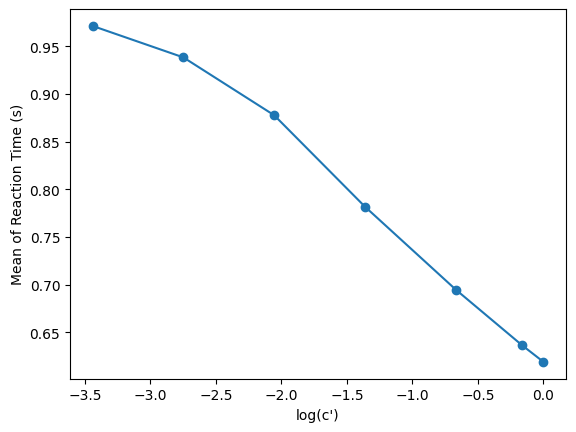

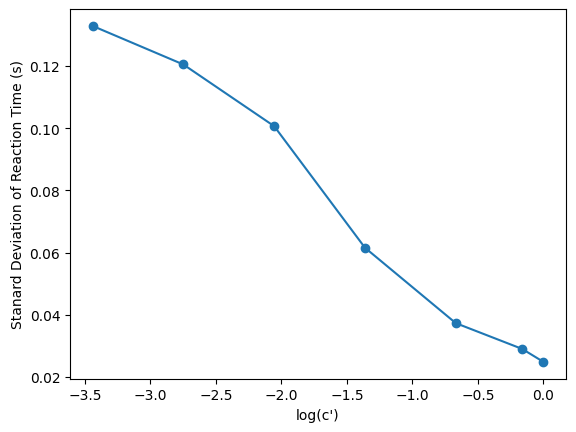

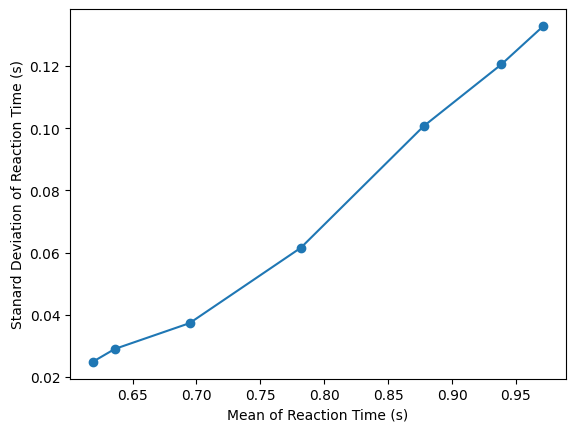

In [ ]:
from __future__ import division
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import matplotlib as mpl


def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))

modelparams = dict(
    gE          = 0.2609,  # nA
    gI          = -0.0497, # cross-inhibition strength [nA] % 
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [s]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu1         = [30], # Stimulus firing rate [Hz] mu_1
    mu2         = [30], # Stimulus firing rate [Hz] mu_2
    Jext        = 0.00052, # Stimulus input strength [nA/Hz]

    # Simulation Run-Time parameter
    Ttotal      = 3, # Total duration of simulation [s]
    Tstim_on    = [0.5], # Time of stimulus onset
    Tstim_off   = [1.5], # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)

class Model(object):
    def __init__(self, modelparams):
        self.params = modelparams.copy()

    # if symmetry index = 0, apply stimulus by mu_1
    # if symmetry index = 1, apply stimulus by mu_2
    def run(self, n_trial=1,symmetryindex=0,cdot=1,mu0=30):
        p = self.params

        p['mu1'] = [mu0*(1+cdot)]
        p['mu2'] = [mu0*(1-cdot)]

        NT = int(p['Ttotal']/p['dt'])
        t_plot = np.arange(NT)*p['dt']
        t_stim1 = (t_plot>p['Tstim_on'][0]) * (t_plot<p['Tstim_off'][0])
        if len(p['Tstim_on']) > 1:
            t_stim2 = (t_plot>p['Tstim_on'][1]) * (t_plot<p['Tstim_off'][1])

        # change order
        if symmetryindex == 1:
            temp = p['mu1']
            p['mu1'] = p['mu2']
            p['mu2'] = temp
   
        # Define g_{ext}\mu_2
        mean_stim1 = np.ones(NT)*p['mu1'][0]*p['Jext'] # [nA]
        mean_stim2 = np.ones(NT)*p['mu2'][0]*p['Jext'] # [nA]
        Istim1_plot1 = mean_stim1 * t_stim1
        Istim2_plot1 = mean_stim2 * t_stim1
        if len(p['Tstim_on']) > 1:
            mean_stim1 = np.ones(NT)*p['mu1'][1]*p['Jext'] # [nA]
            mean_stim2 = np.ones(NT)*p['mu2'][1]*p['Jext'] # [nA]
            Istim1_plot2 = mean_stim1 * t_stim2
            Istim2_plot2 = mean_stim2 * t_stim2
            Istim1_plot = Istim1_plot1 + Istim1_plot2
            Istim2_plot = Istim2_plot1 + Istim2_plot2
        else:
            Istim1_plot = Istim1_plot1
            Istim2_plot = Istim2_plot1
           
        s_0 = 0.1 # initial condition of s
        # Initialize S1 and S2
        S1 = s_0*np.ones(n_trial)
        S2 = s_0*np.ones(n_trial)

        Ieta1 = np.zeros(n_trial)
        Ieta2 = np.zeros(n_trial)

        n_record = int(p['record_dt']//p['dt'])
        i_record = 0
        N_record = int(p['Ttotal']/p['record_dt'])

        self.r1 = np.zeros((N_record, n_trial))
        self.r2 = np.zeros((N_record, n_trial))
        self.s1 = np.zeros((N_record, n_trial))
        self.s2 = np.zeros((N_record, n_trial))
        self.ds1 = np.zeros((N_record, n_trial))
        self.ds2 = np.zeros((N_record, n_trial))

        self.t  = np.zeros(N_record)
        self.I1 = np.zeros(N_record)
        self.I2 = np.zeros(N_record)

        # Loop over time points in a trial
        for i_t in range(NT):
            Istim1 = Istim1_plot[i_t]
            Istim2 = Istim2_plot[i_t]

            # Total synaptic input
            Isyn1 = p['gE']*S1 + p['gI']*S2 + Istim1 + Ieta1
            Isyn2 = p['gE']*S2 + p['gI']*S1 + Istim2 + Ieta2

            # Transfer function to get firing rate
            r1  = F(Isyn1)
            r2  = F(Isyn2)

            # Equation 2 & 3
            S1_next = S1 + p['dt']*(-S1/p['tauS'] + (1-S1)*p['gamma']*r1)
            S2_next = S2 + p['dt']*(-S2/p['tauS'] + (1-S2)*p['gamma']*r2)
            thisds1 = -S1/p['tauS'] + (1-S1)*p['gamma']*r1
            thisds2 = -S2/p['tauS'] + (1-S2)*p['gamma']*r2

            # Equation 4 & 5
            Ieta1_next = Ieta1 + (p['dt']/p['tau0'])*(p['I0']-Ieta1) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)
            Ieta2_next = Ieta2 + (p['dt']/p['tau0'])*(p['I0']-Ieta2) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)

            S1 = S1_next
            S2 = S2_next
            Ieta1 = Ieta1_next
            Ieta2 = Ieta2_next

            if np.mod(i_t,n_record) == 1:
                self.r1[i_record] = r1
                self.r2[i_record] = r2
                self.s1[i_record] = S1
                self.s2[i_record] = S2
                self.ds1[i_record] = thisds1
                self.ds2[i_record] = thisds2
                self.I1[i_record] = Istim1
                self.I2[i_record] = Istim2
                self.t[i_record] = i_t*p['dt']
                i_record += 1


if __name__ == '__main__':
    runtrail = 1
    rerun = 500
    theta_threshold = 15

    cdotset = [0.032,0.064,0.128,0.256,0.512,0.85,1.0]
    mu0val = 30
    meanreaction = []
    stdreaction = []

    for cdotval in cdotset:
        reactiontime = []
        for cnt in range(rerun):
            model = Model(modelparams)
            model.run(n_trial=runtrail,symmetryindex=0,cdot=cdotval,mu0=mu0val)
            for i in range(len(model.t)):
                if (model.r1[i] > theta_threshold and model.r2[i] < theta_threshold) \
                    or (model.r2[i] > theta_threshold and model.r1[i] < theta_threshold):
                    reactiontime.append(model.t[i])
                    break
        meanreaction.append(np.mean(reactiontime))
        stdreaction.append(np.std(reactiontime))

    plt.figure()
    plt.plot(np.log(cdotset),meanreaction,'-o')
    plt.xlabel("log(c')")
    plt.ylabel('Mean of Reaction Time (s)')

    plt.figure()
    plt.plot(np.log(cdotset),stdreaction,'-o')
    plt.xlabel("log(c')")
    plt.ylabel('Stanard Deviation of Reaction Time (s)')

    plt.figure()
    plt.plot(meanreaction,stdreaction,'-o')
    plt.xlabel('Mean of Reaction Time (s)')
    plt.ylabel('Stanard Deviation of Reaction Time (s)')

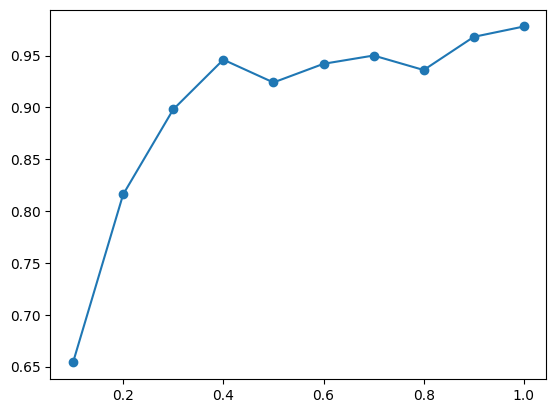

In [ ]:
from __future__ import division
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
import matplotlib as mpl


def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))

modelparams = dict(
    gE          = 0.2609,  # nA
    gI          = -0.0497, # cross-inhibition strength [nA] % 
    I0          = 0.3255, # background current [nA]
    tauS        = 0.1, # Synaptic time constant [s]
    gamma       = 0.641, # Saturation factor for gating variable
    tau0        = 0.002, # Noise time constant [sec]
    sigma       = 0.02, # Noise magnitude [nA]
    mu1         = [30], # Stimulus firing rate [Hz] mu_1
    mu2         = [30], # Stimulus firing rate [Hz] mu_2
    Jext        = 0.00052, # Stimulus input strength [nA/Hz]

    # Simulation Run-Time parameter
    Ttotal      = 3, # Total duration of simulation [s]
    Tstim_on    = [0.5], # Time of stimulus onset
    Tstim_off   = [1.5], # Time of stimulus offset
    dt          = 0.5/1000, # Simulation time step
    record_dt   = 5/1000.
)

class Model(object):
    def __init__(self, modelparams):
        self.params = modelparams.copy()

    # if symmetry index = 0, apply stimulus by mu_1
    # if symmetry index = 1, apply stimulus by mu_2
    def run(self, n_trial=1,symmetryindex=0,cdot=1,mu0=30,T0=1):
        p = self.params

        p['mu1'] = [mu0*(1+cdot)]
        p['mu2'] = [mu0*(1-cdot)]

        p['Tstim_off'] = [p['Tstim_on'][0]+T0]

        NT = int(p['Ttotal']/p['dt'])
        t_plot = np.arange(NT)*p['dt']
        t_stim1 = (t_plot>p['Tstim_on'][0]) * (t_plot<p['Tstim_off'][0])
        if len(p['Tstim_on']) > 1:
            t_stim2 = (t_plot>p['Tstim_on'][1]) * (t_plot<p['Tstim_off'][1])

        # change order
        if symmetryindex == 1:
            temp = p['mu1']
            p['mu1'] = p['mu2']
            p['mu2'] = temp
   
        # Define g_{ext}\mu_2
        mean_stim1 = np.ones(NT)*p['mu1'][0]*p['Jext'] # [nA]
        mean_stim2 = np.ones(NT)*p['mu2'][0]*p['Jext'] # [nA]
        Istim1_plot1 = mean_stim1 * t_stim1
        Istim2_plot1 = mean_stim2 * t_stim1
        if len(p['Tstim_on']) > 1:
            mean_stim1 = np.ones(NT)*p['mu1'][1]*p['Jext'] # [nA]
            mean_stim2 = np.ones(NT)*p['mu2'][1]*p['Jext'] # [nA]
            Istim1_plot2 = mean_stim1 * t_stim2
            Istim2_plot2 = mean_stim2 * t_stim2
            Istim1_plot = Istim1_plot1 + Istim1_plot2
            Istim2_plot = Istim2_plot1 + Istim2_plot2
        else:
            Istim1_plot = Istim1_plot1
            Istim2_plot = Istim2_plot1
           
        s_0 = 0.1 # initial condition of s
        # Initialize S1 and S2
        S1 = s_0*np.ones(n_trial)
        S2 = s_0*np.ones(n_trial)

        Ieta1 = np.zeros(n_trial)
        Ieta2 = np.zeros(n_trial)

        n_record = int(p['record_dt']//p['dt'])
        i_record = 0
        N_record = int(p['Ttotal']/p['record_dt'])

        self.r1 = np.zeros((N_record, n_trial))
        self.r2 = np.zeros((N_record, n_trial))
        self.s1 = np.zeros((N_record, n_trial))
        self.s2 = np.zeros((N_record, n_trial))
        self.ds1 = np.zeros((N_record, n_trial))
        self.ds2 = np.zeros((N_record, n_trial))

        self.t  = np.zeros(N_record)
        self.I1 = np.zeros(N_record)
        self.I2 = np.zeros(N_record)

        # Loop over time points in a trial
        for i_t in range(NT):
            Istim1 = Istim1_plot[i_t]
            Istim2 = Istim2_plot[i_t]

            # Total synaptic input
            Isyn1 = p['gE']*S1 + p['gI']*S2 + Istim1 + Ieta1
            Isyn2 = p['gE']*S2 + p['gI']*S1 + Istim2 + Ieta2

            # Transfer function to get firing rate
            r1  = F(Isyn1)
            r2  = F(Isyn2)

            # Equation 2 & 3
            S1_next = S1 + p['dt']*(-S1/p['tauS'] + (1-S1)*p['gamma']*r1)
            S2_next = S2 + p['dt']*(-S2/p['tauS'] + (1-S2)*p['gamma']*r2)
            thisds1 = -S1/p['tauS'] + (1-S1)*p['gamma']*r1
            thisds2 = -S2/p['tauS'] + (1-S2)*p['gamma']*r2

            # Equation 4 & 5
            Ieta1_next = Ieta1 + (p['dt']/p['tau0'])*(p['I0']-Ieta1) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)
            Ieta2_next = Ieta2 + (p['dt']/p['tau0'])*(p['I0']-Ieta2) + np.sqrt(p['dt']/p['tau0'])*p['sigma']*numpy.random.randn(n_trial)

            S1 = S1_next
            S2 = S2_next
            Ieta1 = Ieta1_next
            Ieta2 = Ieta2_next

            if np.mod(i_t,n_record) == 1:
                self.r1[i_record] = r1
                self.r2[i_record] = r2
                self.s1[i_record] = S1
                self.s2[i_record] = S2
                self.ds1[i_record] = thisds1
                self.ds2[i_record] = thisds2
                self.I1[i_record] = Istim1
                self.I2[i_record] = Istim2
                self.t[i_record] = i_t*p['dt']
                i_record += 1


if __name__ == '__main__':
    runtrail = 1
    rerun = 500
    theta_threshold = 15
    s1preferset = []

    cdotval = 0.128
    Tset = np.linspace(0.1,1.0,num=10)
    mu0val = 30

    for Tval in Tset:
        s1prefer = 0
        for run in range(rerun):
            model = Model(modelparams)
            model.run(n_trial=runtrail,symmetryindex=0,cdot=cdotval,mu0=mu0val,T0=Tval)
            if np.mean(model.r1) > np.mean(model.r2):
                s1prefer += 1

        s1preferset.append(s1prefer/rerun)
    
    plt.figure()
    plt.plot(Tset,s1preferset,'-o')
    
        


Text(0, 0.5, 'Percentage of correct decisions')

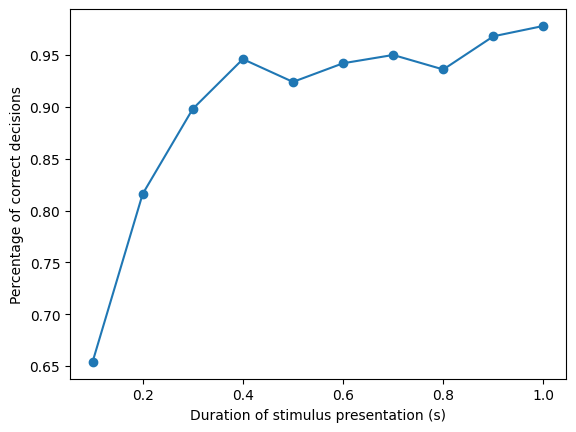

In [ ]:
plt.figure()
plt.plot(Tset,s1preferset,'-o')
plt.xlabel('Duration of stimulus presentation (s)')
plt.ylabel('Percentage of correct decisions')